In [4]:
import pandas as pd
import pyproj
import verde as vd
import harmonica as hm
import bordado as bd
import numpy as np
import rioxarray

# --- CARGA E LIMPEZA INICIAL ---
df_corr = pd.read_csv(
    'marco-mag/data/Magnetometry/merged_data/can_mag_corr.csv', 
    low_memory=False 
)

df_corr.dropna(
    subset=["AMF", "Mag_Northing", "Mag_Easting", "Depth"], 
    inplace=True
)

# --- GARANTIA DE DADOS VÁLIDOS (UTM) ---
filtro_valido = np.isfinite(df_corr.Mag_Easting) & np.isfinite(df_corr.Mag_Northing)
df_clean = df_corr[filtro_valido].copy()

if df_clean.empty:
    raise ValueError("Seu DataFrame está vazio. Verifique os dados de 'Mag_Easting' e 'Mag_Northing' no CSV.")

# -----------------------------------------------------------------
# --- PASSO NOVO E CRUCIAL: FILTRO DE OUTLIERS ESTATÍSTICO ---
# -----------------------------------------------------------------
# Vamos calcular os limites para 99% dos dados (cortando 0.5% em cada ponta)
q_low_e = df_clean.Mag_Easting.quantile(0.005)
q_high_e = df_clean.Mag_Easting.quantile(0.995)
q_low_n = df_clean.Mag_Northing.quantile(0.005)
q_high_n = df_clean.Mag_Northing.quantile(0.995)

# Filtra o DataFrame, mantendo apenas os dados "bons"
df_final = df_clean.loc[
    (df_clean.Mag_Easting >= q_low_e) & (df_clean.Mag_Easting <= q_high_e) &
    (df_clean.Mag_Northing >= q_low_n) & (df_clean.Mag_Northing <= q_high_n)
]

if df_final.empty:
    raise ValueError("Filtragem de outliers removeu todos os dados. Verifique o CSV.")

# --------------------------------------------------
# AGORA, USAMOS 'df_final' PARA TUDO
# --------------------------------------------------

altitude = df_final.Depth
coordinates = (df_final.Mag_Easting, df_final.Mag_Northing, altitude)

# A 'regiao' agora será calculada APENAS com dados bons
regiao = bd.get_region((df_final.Mag_Easting, df_final.Mag_Northing))

# Vamos checar a nova região:
print(f"NOVA Região (sem outliers): {regiao}")
print(f"Nova largura: {(regiao[1] - regiao[0]) / 1000:.1f} km")
print(f"Nova altura: {(regiao[3] - regiao[2]) / 1000:.1f} km")


# ... (cálculo das fontes equivalentes) ...
eqs = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=0.5e3, window_size=1e3, random_state=42
)
pred_points = eqs.fit(coordinates, df_final.AMF) 

# Grid com a 'regiao' correta
spacing = 25.0 
e_grid, n_grid = vd.grid_coordinates(regiao, spacing=spacing)
up_grid = np.full(e_grid.size, 0.0, dtype=np.float32)
coords_grid = (e_grid.ravel(), n_grid.ravel(), up_grid)

pred_grid = eqs.predict(coords_grid).reshape(e_grid.shape)

# wrap as xarray
grid = vd.make_xarray_grid(
    data=pred_grid,
    coordinates=(e_grid, n_grid),
    data_names="AMF_ES",
)
grid_data = grid.AMF_ES

# --- SALVANDO O GeoTIFF ---
grid_data = grid_data.rename({"easting": "x", "northing": "y"})
grid_data.rio.set_spatial_dims("x", "y", inplace=True)
grid_data.rio.set_crs("EPSG:32723", inplace=True) 

output_filename = "mapa_anomalia_mag_CANANEIA_FINAL_v4.tif"
grid_data.rio.to_raster(output_filename)

print(f"Grid FINAL (v4) salvo como '{output_filename}'")

NOVA Região (sem outliers): (197376.08, 802631.03, 7223257.23, 7237997.44)
Nova largura: 605.3 km
Nova altura: 14.7 km


/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used dire

Grid FINAL (v4) salvo como 'mapa_anomalia_mag_CANANEIA_FINAL_v4.tif'


/tmp/ipykernel_17134/3939920065.py:86: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  grid_data.rio.set_crs("EPSG:32723", inplace=True)


Gerando um 'mapa' rápido das suas coordenadas...


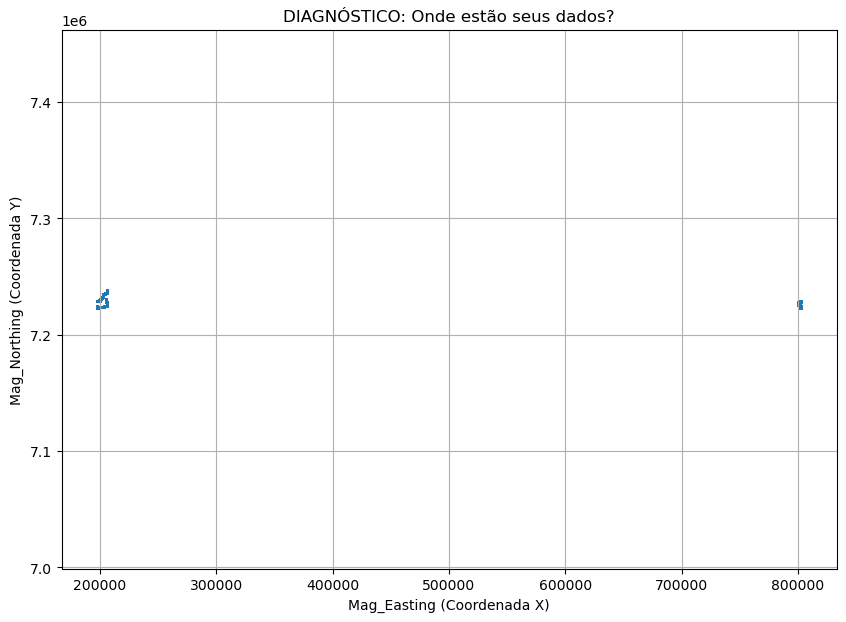

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- CARGA E LIMPEZA BÁSICA ---
df_corr = pd.read_csv(
    'marco-mag/data/Magnetometry/merged_data/can_mag_corr.csv', 
    low_memory=False 
)
df_corr.dropna(
    subset=["Mag_Northing", "Mag_Easting"], 
    inplace=True
)

print("Gerando um 'mapa' rápido das suas coordenadas...")

# --- O DIAGNÓSTICO VISUAL ---
# Vamos plotar um gráfico de dispersão (scatter plot)
# X = Easting, Y = Northing
plt.figure(figsize=(10, 7))
plt.scatter(df_corr.Mag_Easting, df_corr.Mag_Northing, s=1) # s=1 para pontos pequenos
plt.xlabel('Mag_Easting (Coordenada X)')
plt.ylabel('Mag_Northing (Coordenada Y)')
plt.title('DIAGNÓSTICO: Onde estão seus dados?')
plt.grid(True)

# Força o matplotlib a usar uma escala "real" nos eixos
# para podermos ver a distorção
plt.axis('equal') 

plt.show()

In [6]:
import pandas as pd
import pyproj
import verde as vd
import harmonica as hm
import bordado as bd
import numpy as np
import rioxarray

# --- CARGA E LIMPEZA INICIAL ---
df_corr = pd.read_csv(
    'marco-mag/data/Magnetometry/merged_data/can_mag_corr.csv', 
    low_memory=False 
)

df_corr.dropna(
    subset=["AMF", "Mag_Northing", "Mag_Easting", "Depth"], 
    inplace=True
)

# --- GARANTIA DE DADOS VÁLIDOS (UTM) ---
filtro_valido = np.isfinite(df_corr.Mag_Easting) & np.isfinite(df_corr.Mag_Northing)
df_clean = df_corr[filtro_valido].copy()

if df_clean.empty:
    raise ValueError("DataFrame vazio após limpeza inicial.")

# -----------------------------------------------------------------
# --- A CORREÇÃO FINAL (V5): FILTRO MANUAL ---
# -----------------------------------------------------------------
# Baseado no gráfico, vamos manter APENAS os dados com Easting < 400.000
# (Isso vai selecionar o cluster da esquerda e ignorar o da direita)

df_final = df_clean[df_clean.Mag_Easting < 400000].copy()

if df_final.empty:
    raise ValueError("O filtro manual removeu todos os dados. Verifique o valor do filtro.")

# --------------------------------------------------
# AGORA, USAMOS 'df_final' PARA TUDO
# --------------------------------------------------

altitude = df_final.Depth
coordinates = (df_final.Mag_Easting, df_final.Mag_Northing, altitude)

# A 'regiao' agora será calculada APENAS com dados bons
regiao = bd.get_region((df_final.Mag_Easting, df_final.Mag_Northing))

# Vamos checar a nova região:
print(f"VERSÃO 5: Região (filtrada): {regiao}")
print(f"Nova largura: {(regiao[1] - regiao[0]) / 1000:.1f} km")
print(f"Nova altura: {(regiao[3] - regiao[2]) / 1000:.1f} km")


# ... (cálculo das fontes equivalentes) ...
eqs = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=0.5e3, window_size=1e3, random_state=42
)
pred_points = eqs.fit(coordinates, df_final.AMF) 

# Grid com a 'regiao' correta
spacing = 25.0 
e_grid, n_grid = vd.grid_coordinates(regiao, spacing=spacing)
up_grid = np.full(e_grid.size, 0.0, dtype=np.float32)
coords_grid = (e_grid.ravel(), n_grid.ravel(), up_grid)

pred_grid = eqs.predict(coords_grid).reshape(e_grid.shape)

# wrap as xarray
grid = vd.make_xarray_grid(
    data=pred_grid,
    coordinates=(e_grid, n_grid),
    data_names="AMF_ES",
)
grid_data = grid.AMF_ES

# --- SALVANDO O GeoTIFF ---
grid_data = grid_data.rename({"easting": "x", "northing": "y"})
grid_data.rio.set_spatial_dims("x", "y", inplace=True)
grid_data.rio.set_crs("EPSG:32723", inplace=True) 

output_filename = "mapa_anomalia_mag_CANANEIA_FINAL_v5.tif"
grid_data.rio.to_raster(output_filename)

print(f"Grid FINAL (v5) salvo como '{output_filename}'")

VERSÃO 5: Região (filtrada): (197246.83, 206313.67, 7223193.45, 7238185.3)
Nova largura: 9.1 km
Nova altura: 15.0 km


/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used dire

Grid FINAL (v5) salvo como 'mapa_anomalia_mag_CANANEIA_FINAL_v5.tif'


/tmp/ipykernel_17134/3279532292.py:79: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  grid_data.rio.set_crs("EPSG:32723", inplace=True)


Calculando fontes equivalentes...
Criando grid...


/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/gabriel/anaconda3/envs/labgeo/lib/python3.11/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7d2758618cc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used dire


Gerando Plot 1: MAPA RETANGULAR (ANTES DA MÁSCARA)


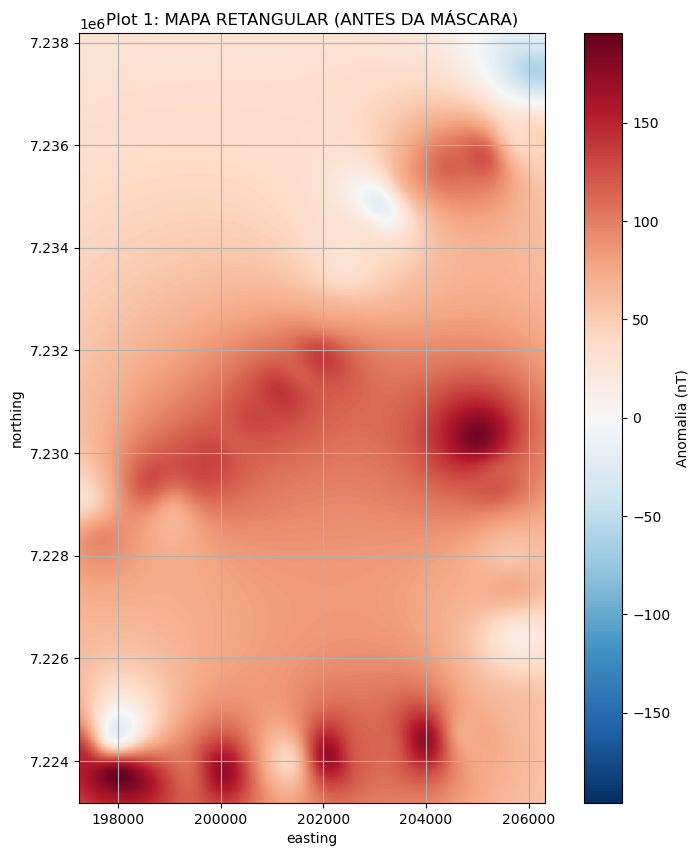

Aplicando máscara do trajeto...


/tmp/ipykernel_17134/3467191472.py:85: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  grid_data.rio.set_crs("EPSG:32723", inplace=True)


Grid FINAL (v11) salvo como 'mapa_anomalia_mag_CANANEIA_HI-RES_v11.tif'

Gerando Plot 2: MAPA MASCARADO (DEPOIS DA MÁSCARA)


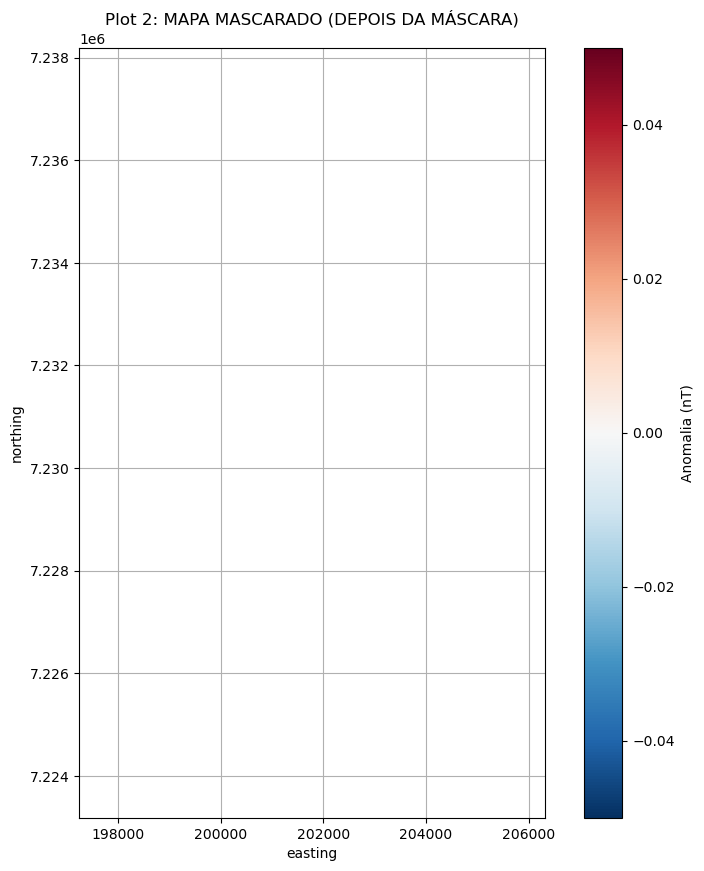

In [12]:
import pandas as pd
import pyproj
import verde as vd
import harmonica as hm
import bordado as bd
import numpy as np
import rioxarray
import matplotlib.pyplot as plt 

# --- CARGA E FILTRO ---
df_corr = pd.read_csv(
    'marco-mag/data/Magnetometry/merged_data/can_mag_corr.csv', 
    low_memory=False 
)
df_corr.dropna(
    subset=["AMF", "Mag_Northing", "Mag_Easting", "Depth"], 
    inplace=True
)
filtro_valido = np.isfinite(df_corr.Mag_Easting) & np.isfinite(df_corr.Mag_Northing)
df_clean = df_corr[filtro_valido].copy()
df_final = df_clean[df_clean.Mag_Easting < 400000].copy()
# -------------------------------------------

# Coordenadas 3D (para o Harmonica)
altitude = df_final.Depth
coordinates_3d = (df_final.Mag_Easting, df_final.Mag_Northing, altitude)

# Coordenadas 2D (para a Máscara)
coordinates_2d = (df_final.Mag_Easting.values, df_final.Mag_Northing.values)

regiao = bd.get_region(coordinates_2d)

# --- CÁLCULO DAS FONTES EQUIVALENTES ---
print("Calculando fontes equivalentes...")
eqs = hm.EquivalentSourcesGB(
    depth=750,  
    damping=10, 
    block_size=0.5e3, 
    window_size=1e3, 
    random_state=42
)
pred_points = eqs.fit(coordinates_3d, df_final.AMF) 

# --- CRIAÇÃO DO GRID RETANGULAR ---
print("Criando grid...")
spacing = 15.0  
e_grid, n_grid = vd.grid_coordinates(regiao, spacing=spacing)
coords_grid = (e_grid.ravel(), n_grid.ravel(), np.full(e_grid.size, 0.0))
pred_grid = eqs.predict(coords_grid).reshape(e_grid.shape)
grid = vd.make_xarray_grid(
    data=pred_grid,
    coordinates=(e_grid, n_grid),
    data_names="AMF_ES",
)

# -----------------------------------------------------------------
# --- PLOT 1: VERIFICAÇÃO DO GRID (ANTES DA MÁSCARA) ---
# -----------------------------------------------------------------
print("\nGerando Plot 1: MAPA RETANGULAR (ANTES DA MÁSCARA)")
plt.figure(figsize=(10, 10))
grid.AMF_ES.plot(
    cmap="RdBu_r", 
    add_colorbar=True,
    add_labels=True,
    cbar_kwargs={'label': 'Anomalia (nT)'}
)
plt.title("Plot 1: MAPA RETANGULAR (ANTES DA MÁSCARA)")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show() # Mostra o primeiro plot

# -----------------------------------------------------------------
# --- APLICAR A MÁSCARA ---
# -----------------------------------------------------------------
print("Aplicando máscara do trajeto...")
maxdist = 1000  # 1000 metros = 1 km
mask = vd.distance_mask(coordinates_2d, maxdist=maxdist, grid=grid)
grid_masked = grid.where(mask == False)
# -----------------------------------------------------------------

# --- SALVANDO O GeoTIFF MASCARADO ---
grid_data = grid_masked.AMF_ES 
grid_data = grid_data.rename({"easting": "x", "northing": "y"})
grid_data.rio.set_spatial_dims("x", "y", inplace=True)
grid_data.rio.set_crs("EPSG:32723", inplace=True) 
output_filename = "mapa_anomalia_mag_CANANEIA_HI-RES_v11.tif"
grid_data.rio.to_raster(output_filename)
print(f"Grid FINAL (v11) salvo como '{output_filename}'")


# -----------------------------------------------------------------
# --- PLOT 2: VERIFICAÇÃO DO GRID (DEPOIS DA MÁSCARA) ---
# -----------------------------------------------------------------
print("\nGerando Plot 2: MAPA MASCARADO (DEPOIS DA MÁSCARA)")
plt.figure(figsize=(10, 10))
grid_masked.AMF_ES.plot(
    cmap="RdBu_r", 
    add_colorbar=True,
    add_labels=True,
    cbar_kwargs={'label': 'Anomalia (nT)'}
)
plt.title("Plot 2: MAPA MASCARADO (DEPOIS DA MÁSCARA)")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show() # Mostra o segundo plot